# Statistical Modeling Report for Financial Client (Proof of Concept)

Date Created: <i>8/29/2018</i>

<b> Goals </b> <br>
A financial institution hopes to gain insights on the types of clients who purchase their auto insurance and the success of their current auto insurance campaign. To understand the current client profile and make predictions on the potential customers who would respond positively to this campaign, we will leverage statistical modeling. 

<b> Models </b> <br>
To address these goals, we considered two types of statistical models: logistic regression, and random forest. <br>
All though many types of models were constructed, we will report on the two models (one from each category of modeling) that yielded the best most accurate and created the greatest insights.

### Overview of the Modeling Types

<b> Logistic Regression: </b> <br>
All regression models relate many predictors to one response variable. In logistic regression, the response variable is binary, meaning it only has two possible outcomes. Consider the current campaign -  the predictors are client demographics (age, education, balance, etc.) and call information (time of call, duration, etc.), and the response is whether or not the client will buy car insurance. Logistic regression takes the logarithmic value of the odds that an event (i.e. the client buys car insurance) will happen, and relates that "logodds" linearly to the values of the predictors. The output the model is a coefficient for each variable that describes how it relates to the "logodds" of the response event.

<b> Random Forest: </b> <br>
The foundation of a random forest is decision trees. Decision trees split the predictors into branches in order to make a classification decision about the response variable. The random forest model iteratively builds and averages hundreds of different decision trees to identify the optimal split across all predictors that will yield the highest significance and best classification accuracy.

# The Data

First, we import the packages. These contain pre-defined functions we use when modeling in Python.

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql as sql
%matplotlib inline
import seaborn as sns; sns.set()
import math
import datetime

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import itertools

import warnings
warnings.filterwarnings("ignore")

# output multiple lines per block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The next code block defines a function to plot a confusion matrix, which we will use later.

In [518]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import the Data

Next, we access the data from the client's MySQL databases. We have to establish a connection to the database, then store the data in local dataframes.

<i>Note: this RDS instance is no longer active</i>

In [ ]:
host="bootcamp-open.ctzjfvqmre0y.us-east-1.rds.amazonaws.com"
port=3306
dbname="team_2"
user="team_2"
password="captechlistens!"

conn = sql.connect(host, user=user,port=port, passwd=password, db=dbname)

In [520]:
combined_table = pd.read_sql('SELECT * FROM team_2.combined_table', con=conn)
conn.close()

In this dataframe, each client has a row with information on their demographics, how they've been contacted during the current campaign, as well as the total number of times they've been contacted across all campaigns.

There are two success columns: Current_Success and Overall_Sucess. These will each be used as seperate response variables in different models.

## Data Cleaning
In order to make sure our data can be used for modeling, we will make some slight adjustments to the dataframe.

### Data Type Handling
First, we have to make sure the data types were read in from SQL correctly.

In [521]:
combined_table.dtypes

ID                        int64
Age                       int64
Gender                   object
Marital                  object
Job                      object
Education                object
Balance                  object
HH_Insurance              int64
Car_Loan                  int64
Default_Flag              int64
Last_Contact             object
Weekday                  object
Days_Passed               int64
Call_Start               object
Hour                    float64
Duration                float64
No_Of_Contacts            int64
Total_No_Of_Contacts      int64
Contacted                 int64
Current_Success         float64
Overall_Success           int64
dtype: object

In [522]:
# change to boolean (0,1 -> True, False)
bool_columns = ['Car_Loan', 'Default_Flag', 'HH_Insurance', 'Contacted', 'Current_Success', 'Overall_Success']
combined_table[bool_columns] = combined_table[bool_columns].astype('bool')

In [523]:
# change to categorical factors
cat_columns = ['Education', 'Gender', 'Job', 'Marital', 'Weekday', 'Hour']
combined_table[cat_columns] = combined_table[cat_columns].astype('category')

In [524]:
# change to dates and times
combined_table['Last_Contact'] = pd.to_datetime(combined_table['Last_Contact'])

In [525]:
# change to float
combined_table['Balance'] = combined_table['Balance'].astype('float')

In [526]:
# drop uninformative columns
combined_table = combined_table.drop(['Call_Start', 'ID'], axis = 1)
    # Call_Start data is encompassed by Hour - this column won't be used in modeling
    # ID is used for indexing - can't provide insights in modeling

In [527]:
combined_table.dtypes # much better!

Age                              int64
Gender                        category
Marital                       category
Job                           category
Education                     category
Balance                        float64
HH_Insurance                      bool
Car_Loan                          bool
Default_Flag                      bool
Last_Contact            datetime64[ns]
Weekday                       category
Days_Passed                      int64
Hour                          category
Duration                       float64
No_Of_Contacts                   int64
Total_No_Of_Contacts             int64
Contacted                         bool
Current_Success                   bool
Overall_Success                   bool
dtype: object

### Removing Outliers:
Very large numeric outliers will skew the results of our model, so we should drop rows for large abnormalities. <br>
Numeric Values: Age, Balance, Days_Passed, Duration, No_Of_Contacts, Total_No_Of_Contacts

#### Age

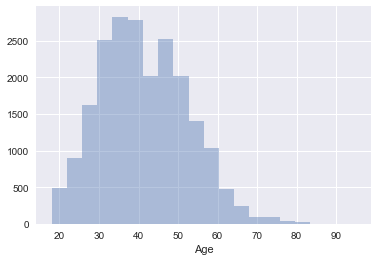

In [528]:
sns.distplot(combined_table.Age, kde = False, bins = 20); # looks good

#### Balance

98417.0

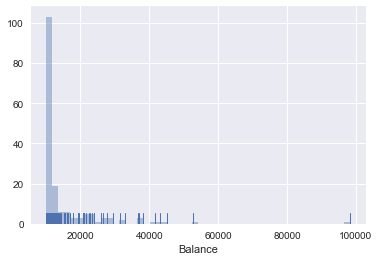

In [529]:
# let's look at the high values
high_balance = combined_table.loc[combined_table['Balance'] > 10000, 'Balance'];
sns.distplot(high_balance, kde = False, rug = True);
high_balance.max() # one account at nearly $100,000.... let's drop this outlier

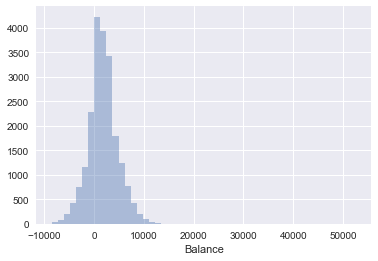

In [530]:
combined_table = combined_table[combined_table.Balance != combined_table.Balance.max()]
combined_table = combined_table.reset_index(drop=True)
sns.distplot(combined_table.Balance, kde = False); # much better!

#### Days_Passed

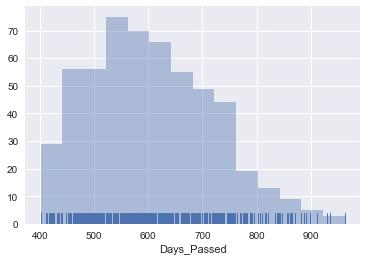

In [531]:
# let's look at the high values
high_dp = combined_table.loc[combined_table['Days_Passed'] > 400, 'Days_Passed'];
sns.distplot(high_dp, kde = False, rug = True); # no problems here

#### Duration

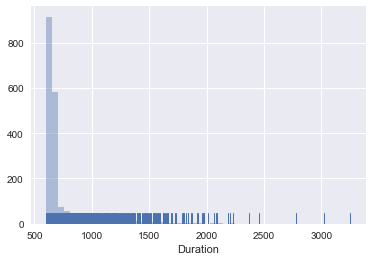

In [532]:
# let's look at the high values
high_duration = combined_table.loc[combined_table['Duration'] > 600, 'Duration'];
sns.distplot(high_duration, kde = False, rug = True); # no problems here

#### No of Contacts

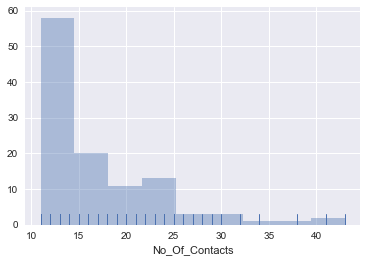

In [533]:
# let's look at the high values
high_noc = combined_table.loc[combined_table['No_Of_Contacts'] > 10, 'No_Of_Contacts'];
sns.distplot(high_noc, kde = False, rug = True); # no problems here

#### Total No Of Contacts

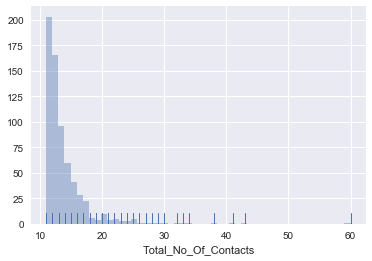

In [534]:
# let's look at the high values
high_tnoc = combined_table.loc[combined_table['Total_No_Of_Contacts'] > 10, 'Total_No_Of_Contacts'];
sns.distplot(high_tnoc, kde = False, rug = True); # 60 contacts is a large outlier... let's remove this

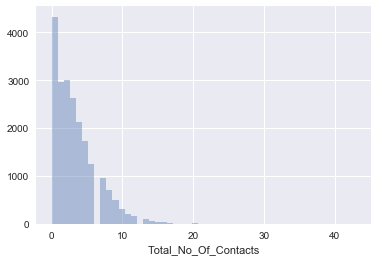

In [535]:
combined_table = combined_table[combined_table.Total_No_Of_Contacts != combined_table.Total_No_Of_Contacts.max()]
combined_table = combined_table.reset_index(drop=True)
sns.distplot(combined_table.Total_No_Of_Contacts, kde = False); # much better!

### Standardize Numeric Values
Large numeric values are overweighed in our models. Therefore, values like balance (ranges up to 50,000) would be deemed more important than values like age (ranges to to 85). To make sure these values can be compared equally, we have to standardize them by centering the means around 0. To do this, we will use the simple standardizing function: <br>
>  value_std = (value - mean) / standard_deviation

In [ ]:
# define standardizing function
def normalize(df):
    columns = df.columns
    output_df = df
    for c in columns: 
        output_df[c+'_Std'] = (df[c] - df[c].mean()) / df[c].std()
        output_df = output_df.drop(c, axis=1)
    return output_df

The next code block will apply our function to create a DataFrame with standardized values. Then, we will join this to our table and drop the original columns.

In [ ]:
num_columns = ['Age', 'Balance', 'Days_Passed', 'Duration', 'No_Of_Contacts', 'Total_No_Of_Contacts']
standardized_table = combined_table[num_columns]
combined_table = combined_table.join(standardized_table)
combined_table = combined_table.drop(num_columns, axis=1)

In [542]:
combined_table.mean() # all numeric variales have a mean very very close to 0

HH_Insurance                5.896307e-01
Car_Loan                    1.816288e-01
Default_Flag                2.050663e-01
Contacted                   7.951705e-01
Current_Success             6.057765e-01
Overall_Success             5.031250e-01
Age_Std                     1.912901e-16
Balance_Std                -5.476837e-16
Days_Passed_Std             1.613987e-15
Duration_Std                7.573588e-17
No_Of_Contacts_Std          1.211116e-14
Total_No_Of_Contacts_Std    5.757366e-15
dtype: float64

### Handling NULL Values
Finally, we have to deal with missing values. Notice that the only missing values are under call info for people who were not contacted during the campaigns. Rather than filter out these missing values, we will create two different data frames: <br>
  > *  <b>contacted1</b>:  clients who were contacted during the first campaign with ALL columns <br>
  > *  <b>clients</b>:  all clients in PFA databases with only columns on patient demographics

In [543]:
combined_table.isnull().sum()

Gender                         0
Marital                        0
Job                            0
Education                      0
HH_Insurance                   0
Car_Loan                       0
Default_Flag                   0
Last_Contact                4326
Weekday                     4326
Hour                        4885
Contacted                      0
Current_Success                0
Overall_Success                0
Age_Std                        0
Balance_Std                    0
Days_Passed_Std                0
Duration_Std                4885
No_Of_Contacts_Std             0
Total_No_Of_Contacts_Std       0
dtype: int64

In [558]:
contacted1 = combined_table.loc[combined_table.Contacted == True]
contacted1 = contacted1.loc[contacted1.Last_Contact >= '2017-08-17']
contacted1 = contacted1.drop('Overall_Success', axis=1)
contacted1.isnull().sum()

Gender                      0
Marital                     0
Job                         0
Education                   0
HH_Insurance                0
Car_Loan                    0
Default_Flag                0
Last_Contact                0
Weekday                     0
Hour                        0
Contacted                   0
Current_Success             0
Age_Std                     0
Balance_Std                 0
Days_Passed_Std             0
Duration_Std                0
No_Of_Contacts_Std          0
Total_No_Of_Contacts_Std    0
dtype: int64

In [559]:
clients = combined_table.drop(['Last_Contact', 'Weekday', 'Hour', 'Contacted', 'Current_Success', 'Days_Passed_Std', 'Duration_Std', 'No_Of_Contacts_Std'], axis=1)
clients.isnull().sum()

Gender                      0
Marital                     0
Job                         0
Education                   0
HH_Insurance                0
Car_Loan                    0
Default_Flag                0
Overall_Success             0
Age_Std                     0
Balance_Std                 0
Total_No_Of_Contacts_Std    0
dtype: int64

# Model 1: Logistic Regression

## What are the biggest indicators of success for the current campaign?
For this analysis, we will be using contacted1 - informaton from the current campaign database joined with the client data.

### Response Variable: Current_Success
Let's check the distribution of success for the current campaign - this mearure will be our response variable.

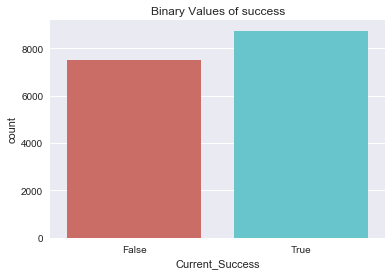

In [560]:
sns.countplot(x='Current_Success', data=contacted1, palette='hls');
plt.title("Binary Values of success");

### Predictor Variables
We have many different types of data in our data set - some are numeric and some are categorical. In logistic regression, ALL predictor variables have to be numeric. To get around this, we will use dummy variables. Dummy variables makes each level in the category it's own variable, then assigns those new variables a 0 or 1 based whether on the level of original variable. For example: <br>
> Old Categorical Variable: Gender = 'M', 'F' <br>
> New Dummy Variables: Gender_M, Gender_F <br>
> Value of Dummy Variables for a Female Client: Gender_M = 0, Gender_F = 1 <br>
> Value of Dummy Variables for a Male Client: Gender_M = 1, Gender_F = 0 <br>

Categorical variables in contacted1: Hour, Weekday, Education, Job, Marital, Gender

In [561]:
cat_vars = ['Hour', 'Weekday', 'Job', 'Gender', 'Education', 'Marital']

df = contacted1

# dummy variables
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1

# set the base case
base_cases = ['Hour_12.0', 'Weekday_Monday', 
              'Job_unemployed', 'Gender_M', 
              'Education_primary', 'Marital_single']

# remove the old categorical variables and the base cases
to_drop = cat_vars + base_cases
contacted1_vars = df.columns.values.tolist()
to_keep = [i for i in contacted1_vars if i not in to_drop]
contacted1_final = df[to_keep]

# check that the dataframe now has the dummy variables as columns
contacted1_final.columns

Index(['HH_Insurance', 'Car_Loan', 'Default_Flag', 'Last_Contact', 'Contacted',
       'Current_Success', 'Age_Std', 'Balance_Std', 'Days_Passed_Std',
       'Duration_Std', 'No_Of_Contacts_Std', 'Total_No_Of_Contacts_Std',
       'Hour_8.0', 'Hour_9.0', 'Hour_10.0', 'Hour_11.0', 'Hour_13.0',
       'Hour_14.0', 'Hour_15.0', 'Hour_16.0', 'Hour_17.0', 'Hour_18.0',
       'Hour_19.0', 'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Job_N/A',
       'Job_admin', 'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Gender_F', 'Education_N/A',
       'Education_secondary', 'Education_tertiary', 'Marital_divorced',
       'Marital_married'],
      dtype='object')

Notice that some dummy variables were chosen as base cases and dropped. This is a comparison baseline for all other levels of that category. For example: <br>
> Old Categorical Variable: Gender = 'M', 'F' <br>
> New Dummy Variables: Gender_M, Gender_F <br>
> Value of Dummy Variables for a Female Client: Gender_M = 0, Gender_F = 1 <br>
> Value of Dummy Variables for a Male Client: Gender_M = 1, Gender_F = 0 <br>
> Base Case: Gender_M <br>
> Value of Dummy Variables for a Female Client: Gender_F = 1 <br>
> Value of Dummy Variables for a Male Client: Gender_F = 0

Base Cases: <br>
> Hour: noon <br>
Weekday: Monday <br>
Education: primary <br>
Job: unemployed <br>
Marital: single <br>
Gender: M

### Model Implementation
We now have all our variables correctly refactored. Set success as the response variable (y) and all other variables as the features (X).

In [562]:
y = contacted1_final['Current_Success']
X = contacted1_final.drop(['Current_Success', 'Contacted', 'Last_Contact'], axis=1) 
    # we can drop ID and contacted, these won't be useful as predictors
    # Last Contact data is encompassed by Days Passed - this column won't be used in modeling

Next, we will do <b>recursive feature selection</b>. This process iterally builds our model using different combination of predictor variables until it settles on the combination of features that gives the most significant model. <br>
This process takes an arguement that specifies the number of features to select. If the argument = 1, it will rank all the features by importance to model. Let's see the rankings for each feature.

In [563]:
# run RFE 
logreg = LogisticRegression()
rfe = RFE(logreg, 1)
rfe = rfe.fit(X.astype(float), y)

# pair the rankings with their feature names in a dataframe
ranked = pd.DataFrame(index=np.arange(0, len(X.columns)), columns=['vars', 'ranking'])
ranked.vars = X.columns
ranked.ranking = rfe.ranking_

# show the features sorted by their ranking (only showing the top 10 features)
ranked.sort_values('ranking')[ranked.ranking <= 10]

,vars,ranking
32,Job_retired,1
0,HH_Insurance,2
42,Marital_married,3
36,Job_technician,4
38,Education_N/A,5
35,Job_student,6
4,Balance_Std,7
2,Default_Flag,8
29,Job_entrepreneur,9
31,Job_management,10


Next, we will split our data into <b>training and testing sets</b>. We build the model on the training set, then check the accuracy using the testing set. The model can generate predictions on the test set, then compare to the actual value of each entry in the test set to compute the accuracy for the model. <br>
Common practice is to make the size of the test set 20-30% of the size of the dataset. Here, we chose 30%

In [564]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [565]:
# generate the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train);

The output of the logistic regression is coefficients for each feature, which describe how the featuer relates to the response variable. Larger positive coefficients indicate a positive indication the current campaign will be a success for that attribute; larger negative coefficients indicate an indication the current campaign will be a failure for that attribute. <br>
Let's add the coefficients from the model to the ranking dataframe so we can see them all together.

In [566]:
# add coefficients to ranked
coeffs = pd.DataFrame(index=np.arange(len(X.columns)), columns = ['vars', 'coeffs'])
coeffs.vars = X.columns
coeffs.coeffs = logreg.coef_.reshape(logreg.coef_.size,1)
ranked = pd.merge(ranked, coeffs, how="inner", on="vars")

# show the features and the coefficients sorted by their ranking
ranked.sort_values('ranking')

,vars,ranking,coeffs
32,Job_retired,1,0.197150
0,HH_Insurance,2,0.740137
42,Marital_married,3,0.621822
36,Job_technician,4,-0.543409
38,Education_N/A,5,0.572816
35,Job_student,6,-0.263216
4,Balance_Std,7,0.247631
2,Default_Flag,8,-0.231822
29,Job_entrepreneur,9,0.143997
31,Job_management,10,0.158567


Next, we can evaluate the <b> accuracy </b> of the model based on the predicitons.

Accuracy of logistic regression classifier on test set: 0.643
Confusion matrix, without normalization
[[ 814  716]
 [ 443 1274]]


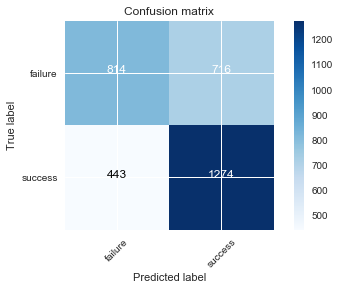

In [567]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['failure', 'success'])

The confusion matrix above describes the accuracy of the model. Adding along the diagonal gives the overall accuracy of the model. Each box sums the predicted versus actual for every entry in the test set.

#  Model 2: Random Forest

## What types of clients will buy insurance with PFA?
For this analysis, we will be using clients - information on all clients.

### Response Variable: Overall_Success
Let's check the distribution of success for the current campaign - this mearure will be our response variable.

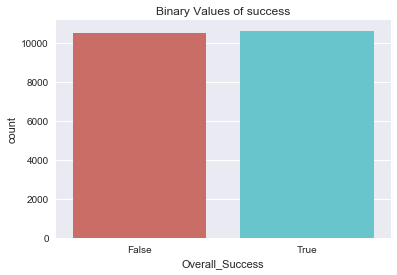

In [552]:
sns.countplot(x='Overall_Success', data=clients, palette='hls');
plt.title("Binary Values of success");

### Predictor Variables
Again, we have many different types of data in our data set - some are numeric and some are categorical. Decision trees also require that all predictors be numeric, so again we will use dummy variables.

In [553]:
cat_vars = ['Education', 'Job', 'Marital', 'Gender']

df = clients

# dummy variables
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1

# set the base case
base_cases = ['Job_unemployed', 'Gender_M', 'Education_primary', 'Marital_single']

# remove the old categorical variables and the base cases
to_drop = cat_vars + base_cases
clients_vars = df.columns.values.tolist()
to_keep = [i for i in clients_vars if i not in to_drop]
clients_final = df[to_keep]

# check that the dataframe now has the dummy variables as columns
clients_final.columns

Index(['HH_Insurance', 'Car_Loan', 'Default_Flag', 'Overall_Success',
       'Age_Std', 'Balance_Std', 'Total_No_Of_Contacts_Std', 'Education_N/A',
       'Education_secondary', 'Education_tertiary', 'Job_N/A', 'Job_admin',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Marital_divorced', 'Marital_married',
       'Gender_F'],
      dtype='object')

Base Cases: <br>
> Education: primary <br>
Job: unemployed <br>
Marital: single <br>
Gender: M

### Model Implementation
We now have all our variables correctly refactored. Set success as the response variable (y) and all other variables as the features (X).

In [554]:
y = clients_final['Overall_Success']
X = clients_final.drop(['Overall_Success'], axis=1)
    # we can drop ID, this won't be useful as predictors

Again, we need to split the data into test and train sets.

In [555]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=222)

Random forest models have many important parameters that must be set to prevent overfitting to the data. For example:
> *  max_features: common practice is to use the number of parameters divided by 3 (set to 8)<br>
> *  max_leaf_nodes: common practice is to have a maximum of 10 final states (set to 10) <br>

In [556]:
# generate the model
clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, max_features=8, random_state=222)
clf = clf.fit(X_train, y_train)

Next, we can evaluate the <b> accuracy </b> of the model based on the predicitons.

Accuracy of logistic regression classifier on test set: 0.663
Confusion matrix, without normalization
[[1200  884]
 [ 541 1599]]


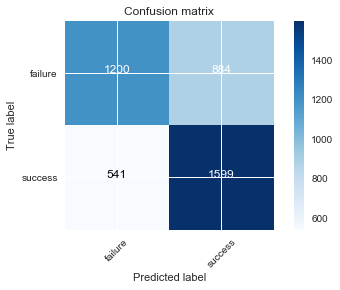

In [557]:
# print the accuracy
y_pred = clf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_score(y_test, y_pred)))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['failure', 'success'])

### List of Clients Model
Because the random forest model performed with higher accuracy and evaluated just the client demographics, we chose to use this model to generate the likelihood percentages we assigned to the list of clients. <br>
These percentages were generated by predicting on the list of clients that had not been contacted. <br>
<i>Note: generating this list of clients is beyond the scope of this code sample.</i>